# Histogram of Oriented Gradients (HOG)

I started experimenting with HOG features by first reading all `vehicle` and `non-vehicle` images. Below are examples of each of them.

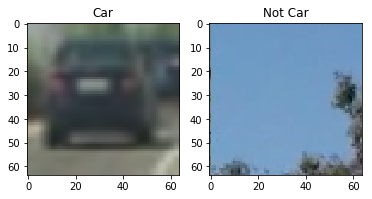

In [1]:
# Get data

%load_ext autoreload
%autoreload 2

import glob

from matplotlib import image as mpimg
from matplotlib import pyplot as plt

from run import visualize

%matplotlib inline


cars = glob.glob('./data/vehicles/**/*.png')
notcars = glob.glob('./data/non-vehicles/**/*.png')

car = mpimg.imread(cars[0])
notcar = mpimg.imread(notcars[0])

fig = plt.figure()
visualize(fig, 1, 2, [car, notcar], ['Car', 'Not Car'])

I then experimented with applying a version of `single_img_features` from the lesson to these images, using various parameters. Below are examples using the parameters used in the lesson (`orientation=8`, `pix_per_cell=8`, `cell_per_block=2`.

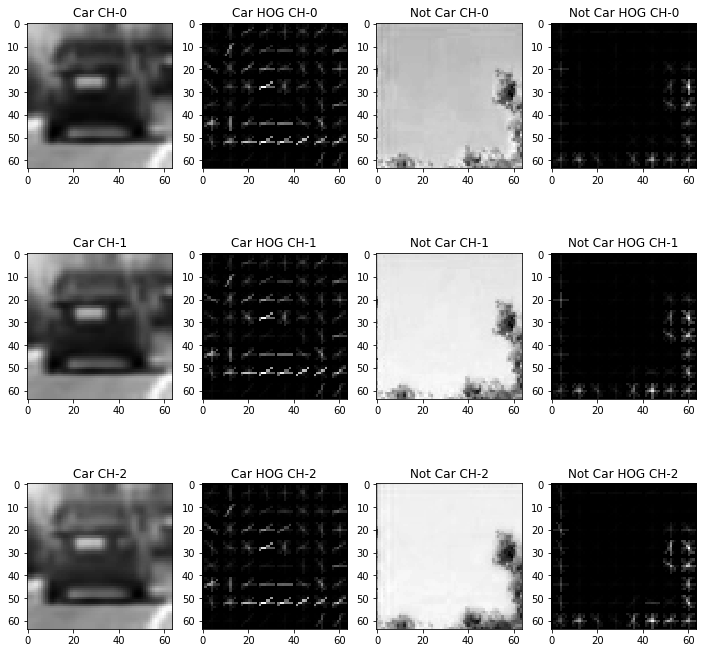

In [3]:
import numpy as np
from features import get_hog_features


imgs, titles = [], []

for ch in [0, 1, 2]:
    _car = car[:,:,ch]
    _notcar = notcar[:,:,ch]
    
    car_feats, car_hog_img = get_hog_features(
        _car,
        orient=8, pix_per_cell=8, cell_per_block=2,
        vis=True
    )
    notcar_feats, notcar_hog_img = get_hog_features(
        _notcar,
        orient=8, pix_per_cell=8, cell_per_block=2,
        vis=True
    )
    imgs += [_car, car_hog_img, _notcar, notcar_hog_img]
    
    titles += [
        'Car CH-{}'.format(ch),
        'Car HOG CH-{}'.format(ch),
        'Not Car CH-{}'.format(ch),
        'Not Car HOG CH-{}'.format(ch)
    ]
    
    
fig = plt.figure(figsize=(12, 12))

visualize(
    fig, 3, 4, 
    imgs, titles,
    cmap='gray'
)

As the image above shows, the default settings actually do a pretty good job of distinguishing between cars and non-cars.

After iteratively playing with the various parameters, I found that changing `orient` to 9, and using `YCrCb` as the color space led to even better results. See examples below.

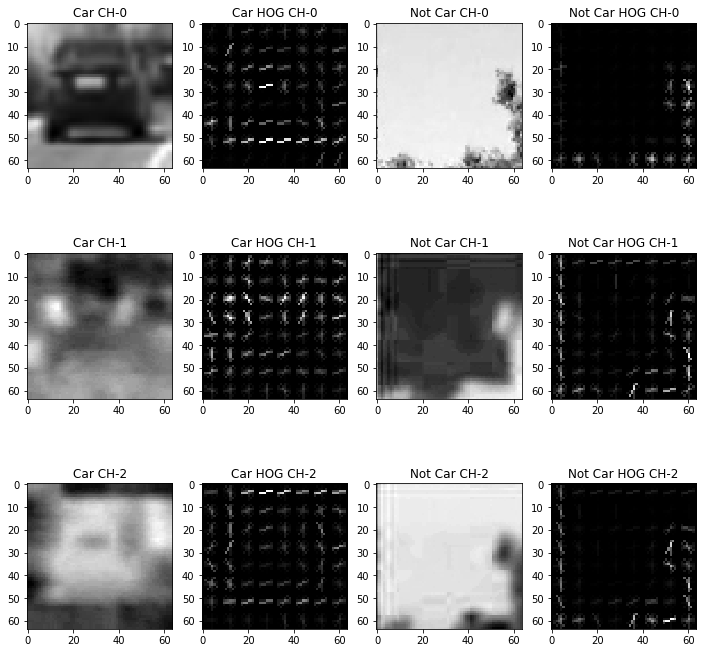

In [6]:
from features import convert_color

# Params

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block


imgs, titles = [], []

feat_car = convert_color(car, color_space)
feat_notcar = convert_color(notcar, color_space)

for ch in [0, 1, 2]:
    _car = feat_car[:,:,ch]
    _notcar = feat_notcar[:,:,ch]
    
    car_feats, car_hog_img = get_hog_features(
        _car,
        orient=orient, 
        pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block,
        vis=True
    )
    notcar_feats, notcar_hog_img = get_hog_features(
        _notcar,
        orient=orient, 
        pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block,
        vis=True
    )
    imgs += [_car, car_hog_img, _notcar, notcar_hog_img]
    
    titles += [
        'Car CH-{}'.format(ch),
        'Car HOG CH-{}'.format(ch),
        'Not Car CH-{}'.format(ch),
        'Not Car HOG CH-{}'.format(ch)
    ]
    
    
fig = plt.figure(figsize=(12, 12))

visualize(
    fig, 3, 4, 
    imgs, titles,
    cmap='gray'
)

The code for feature extraction can be found in `features.py`.

# Training a Classifier

### Data Prep

The next step was to convert the images into features and labels. 

Features were extracted with the `extract_features` function in `features.py`, which passes parameters to `single_img_features` to extract spatial features, histogram features, and HOG features if corresponding flags are set. Features are normalized using `StandardScaler`, as in the lesson.

Labels were extracted by combining a vector of `1`s of length equal to number of cars, and a vector of `0`s of length equal to the number of noncars.

The dataset was split into test and validation sets using `sklearn.model_selectionl.train_test_split`, with 10% of the data used for validation.

### Model

I used a linear SVC as the classifier. The classifier takes ~75s to train, and achieves a 99%+ accuracy on the validation set.

Code for data prep and model training are in `train.py`.

# Sliding Window Search

To search for cars, I used the more performant version of window search given in the project walkthrough. 

This function first extracts HOG features for the entire image one time, instead of doing it per window. We then go through every `x` and `y` step to extract features, normalize, and call prediction on it using the SVC classifier trained in the previous section.

If the prediction is `1`, we draw a rectangle on the image and add the area to our heatmap. The final image and heatmaps are passed back once all windows have been processed.

Below is the final function applied across test images.

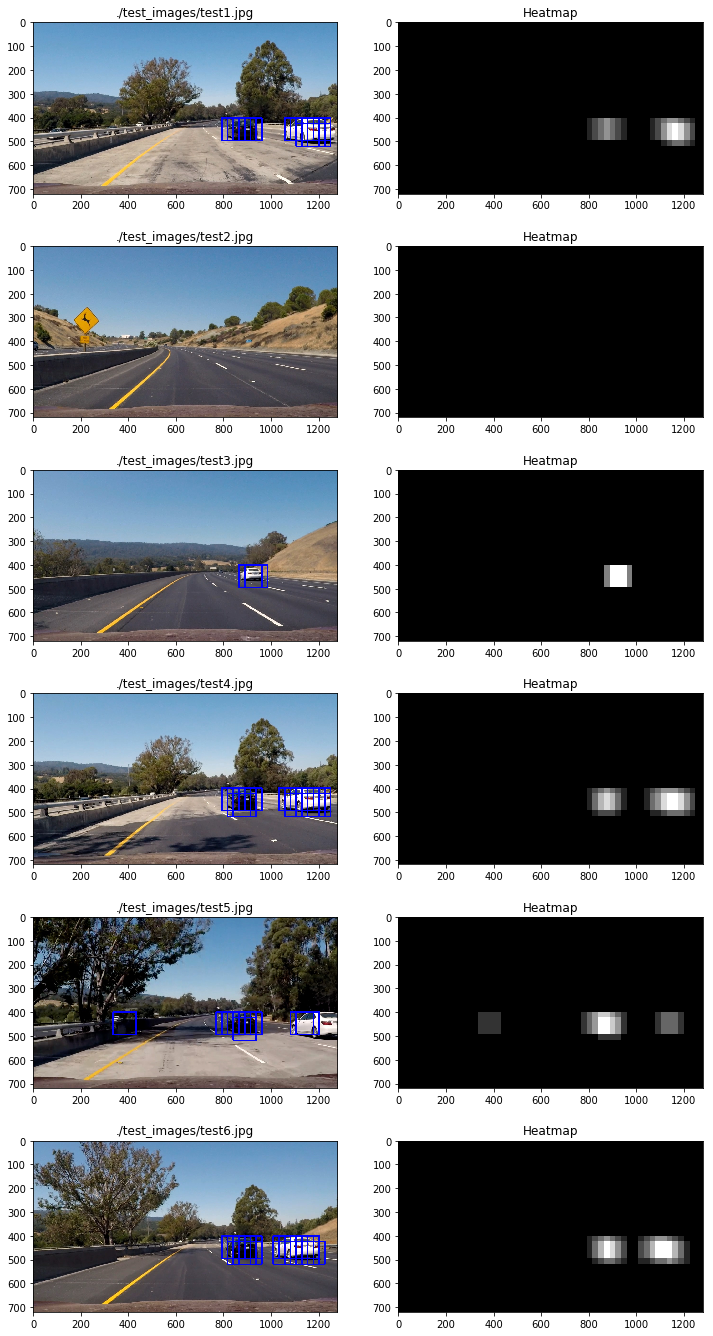

In [25]:
from sklearn.externals import joblib

from search import find_cars

# Test images
test_images = glob.glob('./test_images/*.jpg')

# More feature, search params
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

x_start_stop = [None, None]
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
xy_overlap = (0.5, 0.5)
xy_window = (128, 128)
scale = 1.5

# Load model from pickle
X_scaler = joblib.load('X_scaler.pkl')
model = joblib.load('model.pkl')

# Find cars
imgs, titles = [], []

for img_src in test_images:
    img = mpimg.imread(img_src)
    
    draw_img, heat_map = find_cars(
        img=img,
        svc=model,
        X_scaler=X_scaler,
        x_start_stop=x_start_stop,
        y_start_stop=y_start_stop,
        xy_overlap=xy_overlap,
        xy_window=xy_window,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        spatial_size=spatial_size,
        hist_bins=hist_bins,
        scale=scale        
    )
    imgs += [draw_img, heat_map]
    titles += [img_src, 'Heatmap']
    
# Visualize
fig = plt.figure(figsize=(12, 24))
visualize(
    fig, len(test_images), 2,
    imgs, titles
)

# Post Processing

To limit the number of false positives, I use a threshold of 2 on the heatmap. A bounding box is made using only qualifying pixels. See below for an example of a false positive being removed.

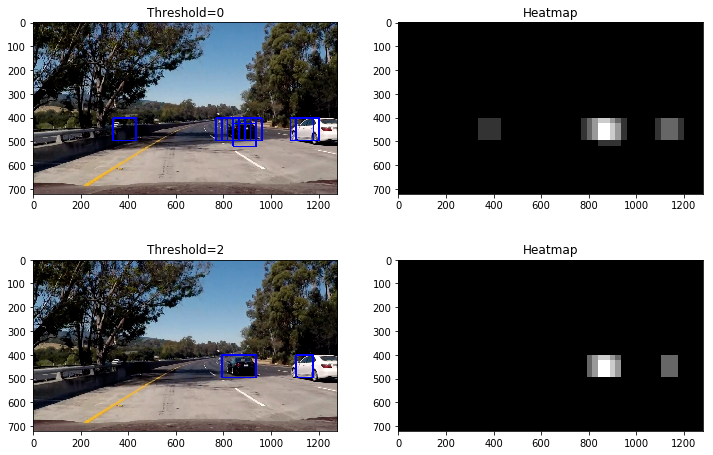

In [27]:
from scipy.ndimage.measurements import label
from search import apply_threshold, draw_labeled_bboxes


threshold = 2
test_img = mpimg.imread('test_images/test5.jpg')

# Raw classified output
draw_img, heatmap = find_cars(
    img=test_img,
    svc=model,
    X_scaler=X_scaler,
    x_start_stop=x_start_stop,
    y_start_stop=y_start_stop,
    xy_overlap=xy_overlap,
    xy_window=xy_window,
    orient=orient,
    pix_per_cell=pix_per_cell,
    cell_per_block=cell_per_block,
    spatial_size=spatial_size,
    hist_bins=hist_bins,
    scale=scale       
)

# Thresholded images
thresh_map = apply_threshold(heatmap, threshold=threshold)
labels = label(thresh_map)
thresh_img = draw_labeled_bboxes(test_img, labels)

fig = plt.figure(figsize=(12, 8))
visualize(
    fig, 2, 2, 
    [draw_img, heatmap, thresh_img, thresh_map],
    ['Threshold=0', 'Heatmap', 'Threshold=2', 'Heatmap']
)

# Video

Below is the resulting video.

In [24]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format('processed_video.mp4'))

# Discussion

The toughest part of this project were the following:

**1) Removing false positives** while maintaining integrity on true positives.

The simplest solution was to increase the heatmap threshold. I tried up to 5, but found the car boxes to be too small. Instead, I lowered the threshold back to 2, and used some heuristics to filter those false positives out. For example, a car should enter the image from the sides, unless it's detected near an existing car (in which case it's the same car). All other "cars" are incorrect guesses from the classifier due to anomalies in the image.

**2) Creating continuity** throughout the video.

This was mostly to reducing cars flickering in and out of frames. To solve this, I updated the prune function to only remove bounding boxes that don't have nearby labels if they're close to the edge of the frame. The solution did well for the most part, but there are still a few frames of flickering near the edges as a result.

**3) Splitting boxes**

Due to the way I was combining and smoothing bounding boxes, the pipeline had a difficult time splitting the bounding box back to two cars once they separated. To solve this, I added explicit logic to use labels directly if there are multiple label matches for a box from the preceding frame.